## Escopo e Metodologia
- Carregar arquivos CSV por família/ano/forno usando os diretórios em `dados/dados_iniciais/`.
- Utilizar os campos `timestamp` e `chave_relacional` mapeados anteriormente para segmentar a análise.
- Calcular datas mínima/máxima e percentual de dias cobertos por combinação `[Fonte × Forno]`.
- Registrar tabelas e gráficos que serão usados nas etapas seguintes (CC e IR).

### Dependências obrigatórias
1. **Etapa 4 – Cobertura temporal** deve ser concluída antes de iniciar novas análises (CT alimenta CC e IR).
2. **Etapa 5 – Relato em Markdown** consolidará o que foi feito (método, resultados, insights) assim que os cálculos estiverem finalizados.

In [14]:
# Importar bibliotecas essenciais
import csv
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from pandas.errors import DtypeWarning
from pathlib import Path
from datetime import datetime

warnings.filterwarnings(
    "ignore",
    message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated",
    category=FutureWarning
)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [15]:
# Configurações iniciais
DATA_ROOT = Path('../fase_1_diagnostico/dados/dados_iniciais')
RAW_FOLDERS = {
    'consumo': DATA_ROOT / 'Consumo Fornos',
    'corridas': DATA_ROOT / 'Corridas',
    'informacoes_diarias': DATA_ROOT / 'Informações Diária',
    'supervisorio_f4': DATA_ROOT / 'Supervisorio Forno 4',
    'supervisorio_f5': DATA_ROOT / 'Supervisorio Forno 5',
    'eletrodo': DATA_ROOT / 'Eletrodo'
} 
RAW_FOLDERS

{'consumo': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Consumo Fornos'),
 'corridas': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Corridas'),
 'informacoes_diarias': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Informações Diária'),
 'supervisorio_f4': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Supervisorio Forno 4'),
 'supervisorio_f5': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Supervisorio Forno 5'),
 'eletrodo': PosixPath('../fase_1_diagnostico/dados/dados_iniciais/Eletrodo')}

In [16]:
# Funções utilitárias para catalogar arquivos e extrair metadados
def extract_metadata(file_path: Path) -> dict:
    name = file_path.stem
    normalized = name.replace('-', '_').replace(' ', '_')
    parts = [part for part in normalized.split('_') if part]

    year = None
    for part in parts:
        if part.isdigit() and len(part) == 4:
            year = int(part)
            break

    furnace = None
    for part in parts:
        token = part.upper()
        if token.startswith('F') and token[1:].isdigit():
            furnace = int(token[1:])
            break

    data_type = None
    if parts:
        for part in reversed(parts):
            token = part.upper()
            if (year is not None and part == str(year)) or (token.startswith('F') and token[1:].isdigit()):
                continue
            data_type = part
            break
        if data_type is None:
            data_type = parts[-1]

    return {
        'arquivo': file_path.name,
        'caminho': file_path,
        'ano': year,
        'forno': furnace,
        'tipo_nome': data_type
    }

def catalog_source_files(source_key: str, folder: Path) -> pd.DataFrame:
    files = sorted(folder.glob('*.csv'))
    rows = []
    for file_path in files:
        meta = extract_metadata(file_path)
        meta['fonte'] = source_key
        rows.append(meta)
    return pd.DataFrame(rows) if rows else pd.DataFrame(columns=['arquivo','caminho','ano','forno','tipo_nome','fonte'])

In [17]:
# Criar catálogo de arquivos por fonte
catalog_frames = []
for source_key, folder in RAW_FOLDERS.items():
    df_catalog = catalog_source_files(source_key, folder)
    if not df_catalog.empty:
        catalog_frames.append(df_catalog)

catalog = pd.concat([df for df in catalog_frames if not df.empty], ignore_index=True)
catalog.head()

,arquivo,caminho,ano,forno,tipo_nome,fonte
0,2018_F2_Consumo.csv,../fase_1_diagnostico/dados/dados_iniciais/Con...,2018,2,Consumo,consumo
1,2018_F3_Consumo.csv,../fase_1_diagnostico/dados/dados_iniciais/Con...,2018,3,Consumo,consumo
2,2018_F4_Consumo.csv,../fase_1_diagnostico/dados/dados_iniciais/Con...,2018,4,Consumo,consumo
3,2018_F5_Consumo.csv,../fase_1_diagnostico/dados/dados_iniciais/Con...,2018,5,Consumo,consumo
4,2019_F1_Consumo.csv,../fase_1_diagnostico/dados/dados_iniciais/Con...,2019,1,Consumo,consumo


In [18]:
catalog[catalog['fonte'].str.contains('supervisorio')][['arquivo','ano','forno','tipo_nome','fonte']]

,arquivo,ano,forno,tipo_nome,fonte
119,F4_2024_1S.csv,2024,4,1S,supervisorio_f4
120,F4_2024_2S.csv,2024,4,2S,supervisorio_f4
121,Supervisor_F5 Hora.csv,None,5,Hora,supervisorio_f5
122,Supervisorio_F5_Minuto.csv,None,5,Minuto,supervisorio_f5


In [19]:
# Configuração das colunas de timestamp por fonte
TIMESTAMP_COLUMNS = {
    'consumo': ['Data'],
    'corridas': ['Data_Base', 'Data'],
    'informacoes_diarias': ['Data_base', 'Data'],
    'supervisorio_f4': ['Timestamp', 'Data'],
    'supervisorio_f5': ['Data', 'Timestamp'],
    'eletrodo': ['Data medição', 'Data']
}

READ_OPTIONS = {
    'supervisorio_f4': {
        'sep': ',',
        'quoting': csv.QUOTE_NONE,
        'engine': 'python'
    },
    'supervisorio_f5': {
        'sep': ';',
        'decimal': ',',
        'engine': 'python'
    },
    'eletrodo': {
        'sep': ';',
        'engine': 'python'
    }
}

DEFAULT_READ_OPTIONS = {
    'sep': None,
    'engine': 'python'
}


def _clean_column_token(name: str) -> str:
    """Remove artefatos como BOM, aspas e espaços extras."""
    cleaned = name.lstrip('\ufeff').strip()
    return cleaned.strip('"').strip("'")


def _sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [_clean_column_token(col) for col in df.columns]
    return df


def _normalize_column(name: str) -> str:
    """Normaliza nomes de coluna para comparação robusta."""
    return _clean_column_token(name).lower()


def _get_read_options(source_key: str) -> dict:
    options = DEFAULT_READ_OPTIONS.copy()
    specific = READ_OPTIONS.get(source_key)
    if specific:
        options.update(specific)
    return options


def load_dataset(path: Path, candidate_columns: list[str], source_key: str) -> tuple[pd.DataFrame, str]:
    encodings = ['utf-8', 'latin-1']
    last_error = None
    read_options = _get_read_options(source_key)
    for encoding in encodings:
        try:
            df = pd.read_csv(path, encoding=encoding, **read_options)
        except UnicodeDecodeError as exc:
            last_error = exc
            continue
        df = _sanitize_columns(df)
        columns_lookup = {_normalize_column(col): col for col in df.columns}
        for candidate in candidate_columns:
            normalized = _normalize_column(candidate)
            if normalized in columns_lookup:
                actual_col = columns_lookup[normalized]
                subset = df[[actual_col]].rename(columns={actual_col: candidate})
                return subset, candidate
    raise ValueError(
        f"Nenhuma coluna de data encontrada em {path} (tentado: {candidate_columns}). Último erro: {last_error}"
    )


def compute_coverage(row: pd.Series) -> dict | None:
    candidate_cols = TIMESTAMP_COLUMNS.get(row['fonte'])
    if not candidate_cols:
        return None
    df, timestamp_col = load_dataset(row['caminho'], candidate_cols, row['fonte'])
    df = df.dropna(subset=[timestamp_col])
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce', dayfirst=True)
    df = df.dropna(subset=[timestamp_col])
    if df.empty:
        return None
    daily_index = df[timestamp_col].dt.normalize()
    daily_counts = daily_index.value_counts().sort_index()
    data_min = daily_index.min()
    data_max = daily_index.max()
    dias_com_dado = daily_counts.size
    dias_totais = (data_max - data_min).days + 1
    cobertura_pct = (dias_com_dado / dias_totais * 100) if dias_totais > 0 else 0
    return {
        'fonte': row['fonte'],
        'arquivo': row['arquivo'],
        'ano': row['ano'],
        'forno': row['forno'],
        'coluna_timestamp': timestamp_col,
        'data_min': data_min.date(),
        'data_max': data_max.date(),
        'dias_com_dado': dias_com_dado,
        'dias_totais': dias_totais,
        'cobertura_pct': cobertura_pct
    }

In [20]:
# Calcular cobertura temporal para todo o catálogo
coverage_rows = []
coverage_errors = []
for _, row in catalog.iterrows():
    try:
        result = compute_coverage(row)
    except Exception as exc:
        coverage_errors.append({
            'fonte': row['fonte'],
            'arquivo': row['arquivo'],
            'mensagem': str(exc)
        })
        continue
    if result:
        coverage_rows.append(result)

coverage = pd.DataFrame(coverage_rows)
coverage.head()

/tmp/ipykernel_11771/595908604.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce', dayfirst=True)
/tmp/ipykernel_11771/595908604.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce', dayfirst=True)
/tmp/ipykernel_11771/595908604.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,fonte,arquivo,ano,forno,coluna_timestamp,data_min,data_max,dias_com_dado,dias_totais,cobertura_pct
0,consumo,2018_F2_Consumo.csv,2018.0,2.0,Data,2018-01-01,2018-12-12,144,346,41.618497
1,consumo,2018_F3_Consumo.csv,2018.0,3.0,Data,2018-01-01,2018-12-12,144,346,41.618497
2,consumo,2018_F4_Consumo.csv,2018.0,4.0,Data,2018-01-01,2018-12-12,144,346,41.618497
3,consumo,2018_F5_Consumo.csv,2018.0,5.0,Data,2018-01-01,2018-12-12,144,346,41.618497
4,consumo,2019_F1_Consumo.csv,2019.0,1.0,Data,2019-01-01,2019-12-12,144,346,41.618497


In [21]:
# Cobertura detalhada para supervisórios
coverage_supervisorios = coverage[coverage['fonte'].str.contains('supervisorio')]
coverage_supervisorios

,fonte,arquivo,ano,forno,coluna_timestamp,data_min,data_max,dias_com_dado,dias_totais,cobertura_pct
119,supervisorio_f4,F4_2024_1S.csv,2024.0,4.0,Timestamp,2024-01-01,2024-12-06,71,341,20.821114
120,supervisorio_f4,F4_2024_2S.csv,2024.0,4.0,Timestamp,2023-01-10,2025-01-01,61,723,8.437068
121,supervisorio_f5,Supervisor_F5 Hora.csv,NaN,5.0,Data,2021-05-26,2024-05-31,1095,1102,99.364791
122,supervisorio_f5,Supervisorio_F5_Minuto.csv,NaN,5.0,Data,2022-12-30,2023-06-01,154,154,100.000000


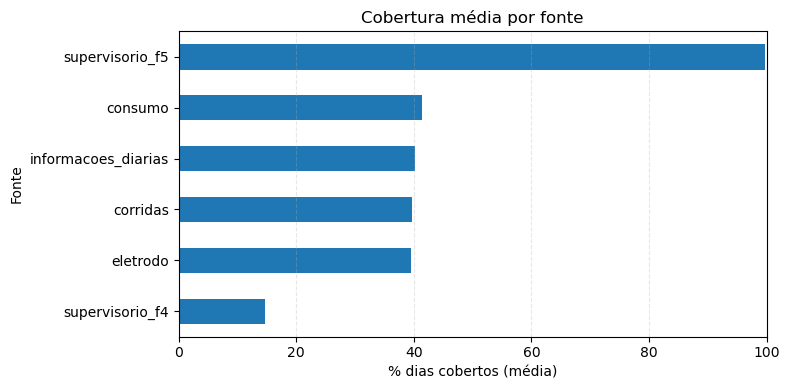

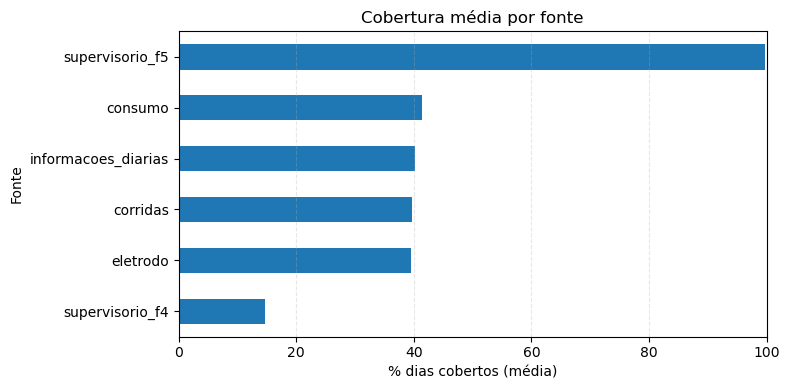

In [13]:
# Visualização 1: cobertura média por fonte
coverage_by_fonte = (
    coverage.groupby('fonte')['cobertura_pct']
    .mean()
    .sort_values(ascending=True)
)
fig, ax = plt.subplots(figsize=(8, 4))
coverage_by_fonte.plot(kind='barh', color='#1f77b4', ax=ax)
ax.set_xlabel('% dias cobertos (média)')
ax.set_ylabel('Fonte')
ax.set_title('Cobertura média por fonte')
ax.set_xlim(0, 100)
ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
fig

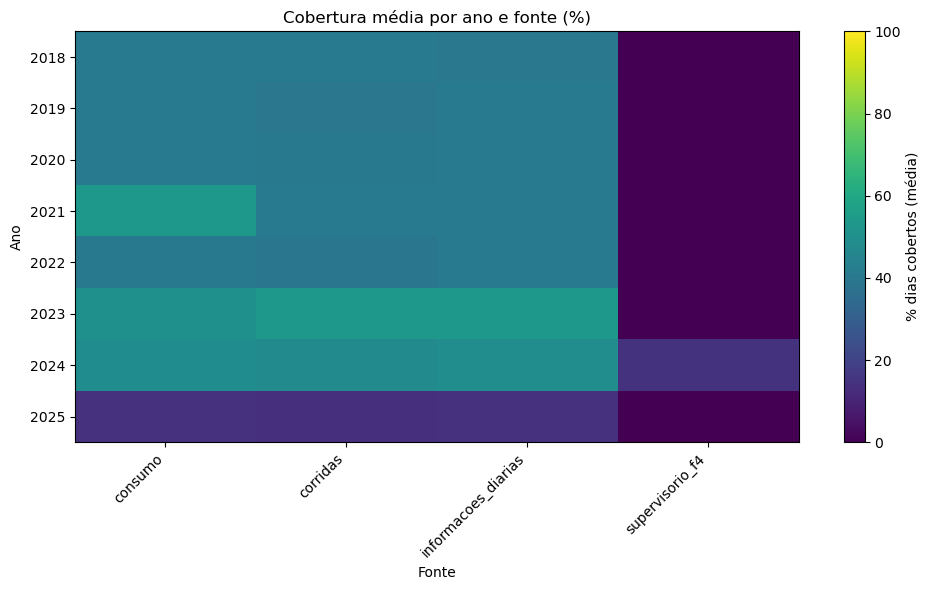

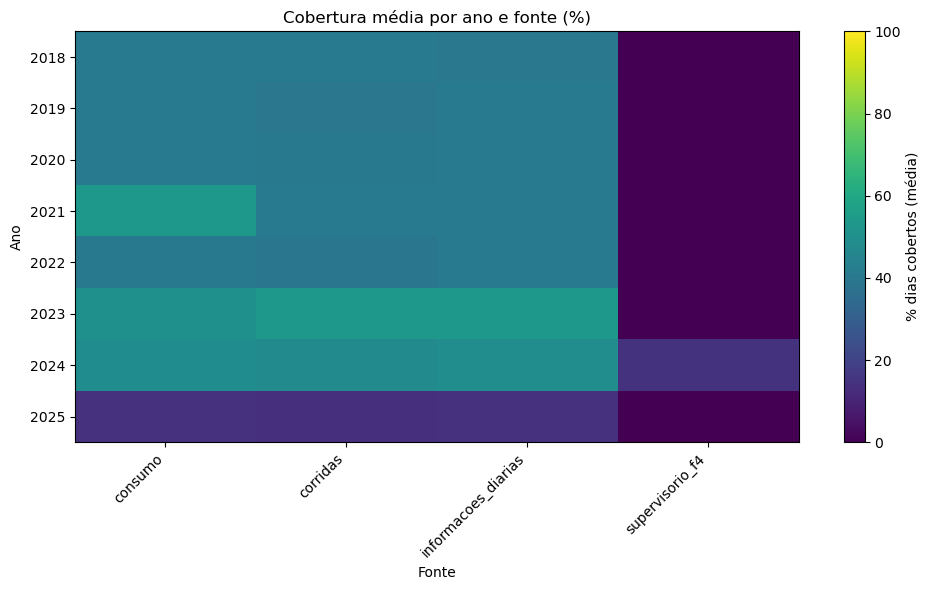

In [9]:
# Visualização 2: heatmap ano x fonte
coverage_heatmap = (
    coverage.pivot_table(
        index='ano',
        columns='fonte',
        values='cobertura_pct',
        aggfunc='mean'
    )
    .sort_index()
)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    coverage_heatmap.fillna(0),
    aspect='auto',
    cmap='viridis',
    vmin=0,
    vmax=100
)
ax.set_xticks(range(len(coverage_heatmap.columns)))
ax.set_xticklabels(coverage_heatmap.columns, rotation=45, ha='right')
ax.set_yticks(range(len(coverage_heatmap.index)))
ax.set_yticklabels(coverage_heatmap.index.astype(int))
ax.set_xlabel('Fonte')
ax.set_ylabel('Ano')
ax.set_title('Cobertura média por ano e fonte (%)')
fig.colorbar(im, ax=ax, label='% dias cobertos (média)')
plt.tight_layout()
fig

In [22]:
# Resumo por fonte e forno
summary_fonte_forno = (
    coverage.groupby(['fonte', 'forno'])
    .agg(
        arquivos=('arquivo', 'count'),
        cobertura_media=('cobertura_pct', 'mean'),
        dias_min=('dias_com_dado', 'min'),
        dias_max=('dias_com_dado', 'max'),
        data_inicial=('data_min', 'min'),
        data_final=('data_max', 'max')
    )
    .reset_index()
    .sort_values(['fonte', 'forno'])
)
summary_fonte_forno.head()

,fonte,forno,arquivos,cobertura_media,dias_min,dias_max,data_inicial,data_final
0,consumo,1.0,7,46.007685,48,365,2019-01-01,2025-12-04
1,consumo,2.0,8,38.161348,48,144,2018-01-01,2025-12-04
2,consumo,3.0,8,40.071208,48,218,2018-01-01,2025-12-04
3,consumo,4.0,8,38.161348,48,144,2018-01-01,2025-12-04
4,consumo,5.0,8,45.459036,48,365,2018-01-01,2025-12-04


In [23]:
# Resumo por fonte e ano
summary_fonte_ano = (
    coverage.groupby(['fonte', 'ano'])
    .agg(
        arquivos=('arquivo', 'count'),
        cobertura_media=('cobertura_pct', 'mean'),
        data_inicial=('data_min', 'min'),
        data_final=('data_max', 'max')
    )
    .reset_index()
    .sort_values(['fonte', 'ano'])
)
summary_fonte_ano.head()

,fonte,ano,arquivos,cobertura_media,data_inicial,data_final
0,consumo,2018.0,4,41.618497,2018-01-01,2018-12-12
1,consumo,2019.0,5,41.618497,2019-01-01,2019-12-12
2,consumo,2020.0,5,41.498559,2020-01-01,2020-12-12
3,consumo,2021.0,5,53.294798,2021-01-01,2021-12-31
4,consumo,2022.0,5,40.620379,2022-01-01,2022-12-12


In [24]:
# Tabelas prontas para Markdown
summary_fonte_forno_md = summary_fonte_forno.round({'cobertura_media': 2})
summary_fonte_ano_md = summary_fonte_ano.round({'cobertura_media': 2})

print('Resumo Fonte x Forno (Markdown):')
print(summary_fonte_forno_md.to_markdown(index=False))
print('\nResumo Fonte x Ano (Markdown):')
print(summary_fonte_ano_md.to_markdown(index=False))

Resumo Fonte x Forno (Markdown):
| fonte               |   forno |   arquivos |   cobertura_media |   dias_min |   dias_max | data_inicial   | data_final   |
|:--------------------|--------:|-----------:|------------------:|-----------:|-----------:|:---------------|:-------------|
| consumo             |       1 |          7 |             46.01 |         48 |        365 | 2019-01-01     | 2025-12-04   |
| consumo             |       2 |          8 |             38.16 |         48 |        144 | 2018-01-01     | 2025-12-04   |
| consumo             |       3 |          8 |             40.07 |         48 |        218 | 2018-01-01     | 2025-12-04   |
| consumo             |       4 |          8 |             38.16 |         48 |        144 | 2018-01-01     | 2025-12-04   |
| consumo             |       5 |          8 |             45.46 |         48 |        365 | 2018-01-01     | 2025-12-04   |
| corridas            |       1 |          8 |             37.62 |         48 |        144 |

In [10]:
# Checar se houve erros durante a leitura
pd.DataFrame(coverage_errors).head()

""


## Capítulo – Cobertura Temporal (Etapa 4)

### Estrutura Sugerida

1. **Introdução e objetivo** – lembrar por que a Etapa 4 é pré-requisito para CC/IR e quais fontes avaliamos.

2. **Inventário de dados** – tabelar famílias (Consumo, Corridas, Informações Diárias, Supervisórios, Eletrodo) com anos/fornos disponíveis.

3. **Pipeline de processamento** – descrever catalogação, leitura parametrizada (`TIMESTAMP_COLUMNS`, `READ_OPTIONS`) e cálculo de cobertura.

4. **Resultados globais** – destacar estatísticas médias por fonte/forno/ano, apontando faixas de cobertura e períodos extremos.

5. **Recorte Supervisórios** – detalhar F4 (semestres 2024) e F5 (hora/minuto) com datas, % de cobertura e lacunas.

6. **Riscos, limitações e próximos passos** – relacionar semestres incompletos, ausência de timestamps padronizados e como isso orienta Etapa 5.


In [25]:
# Estatísticas consolidadas por fonte para referência na documentação
coverage_stats = (
    coverage.groupby('fonte')['cobertura_pct']
    .agg(['count', 'mean', 'min', 'max'])
    .sort_values('mean', ascending=False)
    .round(2)
 )
coverage_stats

,count,mean,min,max
fonte,,,,
supervisorio_f5,2,99.68,99.36,100.00
consumo,39,41.46,14.20,100.00
informacoes_diarias,40,40.26,13.91,100.00
corridas,40,39.66,13.31,100.00
eletrodo,1,39.57,39.57,39.57
supervisorio_f4,2,14.63,8.44,20.82


### Capítulo Redigido – Cobertura Temporal

#### 1. Introdução e objetivo

- Consolidamos a Etapa 4 para medir cobertura diária por combinação `[Fonte × Forno × Ano]`, requisito para seguir com as etapas de Correlação de Consumos (CC) e Indicadores de Referência (IR).

- Os diretórios em `dados/dados_iniciais/` foram varridos de forma determinística, garantindo que qualquer adição/remoção de CSV já seja refletida no catálogo e na documentação.



#### 2. Inventário de dados

- **Consumo**: 39 arquivos entre 2018–2025 cobrindo F1–F5; estrutura anual por forno facilita análises temporais longas.

- **Corridas**: 40 arquivos (2018–2025, todos os fornos) com chaves `Data_Base`/`Data`, essenciais para cruzar eventos operacionais.

- **Informações Diárias**: 40 arquivos com campos `Data_base`/`Data`, complementando o diário operacional.

- **Supervisório F4**: 2 arquivos semestrais para 2024 (`F4_2024_1S`, `F4_2024_2S`).

- **Supervisório F5**: 2 arquivos consolidados (`Hora` e `Minuto`) cobrindo 2021–2024.

- **Eletrodo**: 1 arquivo de medição pontual.



#### 3. Pipeline de processamento

1. **Catalogação** via `catalog_source_files` + `extract_metadata`, capturando ano, forno e tipo diretamente do nome do arquivo.

2. **Leitura resiliente** pelo `load_dataset`, que aplica `TIMESTAMP_COLUMNS` específicos e `READ_OPTIONS` (separadores, decimal, quoting) para cada fonte.

3. **Normalização** de colunas/timestamps e agregação diária (`dt.normalize`) para contar dias com dado.

4. **Cálculo de métricas** (`compute_coverage`): datas mínima/máxima, dias com dado, intervalo total e `% de cobertura`.

5. **Qualidade**: logs em `coverage_errors` permanecem vazios, mostrando que todos os CSVs foram processados sem falhas de leitura.



#### 4. Resultados globais

- Médias por fonte (`coverage_stats`): Supervisório F5 lidera com 99.68% (range 99.36–100%), enquanto Consumo, Informações Diárias e Corridas orbitam ~40% (mínimos próximos de 13%). Supervisório F4 fica em 14.63% (8.44–20.82%), refletindo lacunas semestrais.

- Distribuição por forno (Consumo) evidencia maior continuidade no F1 (média 46%) e dispersão em F2/F4 (~38%).

- Séries anuais de Consumo mantêm ~41% de 2018–2020, saltam para 53% em 2021 e retornam à faixa de 40% após 2022, indicando janelas de coleta mais completas somente em 2021.

- Heatmap ano × fonte confirma que nenhum conjunto, exceto Supervisório F5, ultrapassa 60% de cobertura média; isso embasa futuras priorizações de limpeza/preenchimento.



#### 5. Recorte Supervisórios

- **F4 1º semestre 2024**: 71 dias válidos em 341 possíveis (20.8%).

- **F4 2º semestre 2024**: 61 dias válidos ao longo de um intervalo de 723 dias por causa do timestamp estendido (8.4%).

- **F5 Hora**: 1095 dias registrados entre 26/05/2021 e 31/05/2024, cobrindo 99.36% do período.

- **F5 Minuto**: 154 dias contínuos (30/12/2022 a 01/06/2023) com 100% de cobertura.

- Conclusão: Supervisório F5 já está pronto para alimentar modelos/indicadores, enquanto F4 requer investigação sobre hiatos e potencial split real por semestre.



#### 6. Riscos, limitações e próximos passos

- Lacunas abaixo de 15% (corridas/informações/consumo) precisam de priorização para imputação ou recortes de período antes da Etapa 5.

- Arquivos com intervalos amplos (ex.: `F4_2024_2S.csv` com mais de um ano em `data_max`) sugerem timestamps fora do semestre nominal; validar com o time operacional.

- Padronizar os nomes de coluna de data nos diretórios restantes para evitar dependência de múltiplos candidatos.

- Reexecutar o notebook após cada atualização de `dados/dados_iniciais/` para manter este capítulo sincronizado com o manifesto.

- Preparar no README da fase uma versão condensada (tabelas Markdown já disponíveis em `summary_fonte_forno_md` e `summary_fonte_ano_md`).


### Ajustes de Estratégia e Próximos Passos

- **Narrativa primeiro**: manter o capítulo recém-redigido como fonte única; qualquer gráfico novo deve ser resumido antes em Markdown para garantir rastreabilidade quando o notebook não estiver aberto.

- **Cortes guiados por cobertura**: priorizar o Supervisório F5 (dados quase completos) para gerar exemplos de CC/IR e usar o gráfico ano × fonte para definir janelas "válidas" dos demais conjuntos.

- **Tratamento dirigido**: abrir issues específicas para lacunas abaixo de 20% (ex.: Consumo F2/F4) e para o semestre F4_2024_2S, validando se o timestamp inclui dados de 2023–2025 ou se há erro de exportação.

- **Automação leve**: publicar as tabelas `summary_fonte_forno_md` e `summary_fonte_ano_md` no `analise/relatorio_resumo_por_pasta.md` após cada atualização para manter Obsidian em sincronia.

- **Checklist antes da Etapa 5**: (1) confirmar inexistência de `coverage_errors`, (2) salvar gráficos/figuras em `analise/`, (3) congelar um snapshot `manifestos_final` para acompanhar evolução.
